## Qiskit quantum neural network (QNN) tutorial
In this notebook, we implement a quantum neural network (QNN) for a data classification task. Our dataset consists of images containing horizontal and vertical stripes, and our goal is to label unseen images into one of the two categories depending on the orientation of their line. As the ansatz of our QNN, we specifically construct a [quantum convolutional neural network](https://www.nature.com/articles/s41567-019-0648-8) (QCNN). For data generation and ansatz construction, we follow the strategy found [here](https://qiskit-community.github.io/qiskit-machine-learning/tutorials/11_quantum_convolutional_neural_networks.html).

### Data generation
We start by randomly generating a dataset consisting of 2x4 images with horizontal and vertical lines. Images with horizontal lines are labeled -1 and vertical with +1.

In [1]:
import numpy as np 


def generate_dataset(num_images):
    images = []
    labels = []
    hor_array = np.zeros((6, 8))
    ver_array = np.zeros((4, 8))

    j = 0
    for i in range(0, 7):
        if i != 3:
            hor_array[j][i] = np.pi / 2
            hor_array[j][i + 1] = np.pi / 2
            j += 1

    j = 0
    for i in range(0, 4):
        ver_array[j][i] = np.pi / 2
        ver_array[j][i + 4] = np.pi / 2
        j += 1

    for n in range(num_images):
        rng = np.random.randint(0, 2)
        if rng == 0:
            labels.append(-1)
            random_image = np.random.randint(0, 6)
            images.append(np.array(hor_array[random_image]))
        elif rng == 1:
            labels.append(1)
            random_image = np.random.randint(0, 4)
            images.append(np.array(ver_array[random_image]))

        # Create noise
        for i in range(8):
            if images[-1][i] == 0:
                images[-1][i] = np.random.rand() * np.pi / 4
    return images, labels

We split the generated data into training and test sets.

In [2]:
from sklearn.model_selection import train_test_split

np.random.seed(42)
images, labels = generate_dataset(50)

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3, random_state=246
)

We can now display some images from the dataset with horizontal or vertical lines.

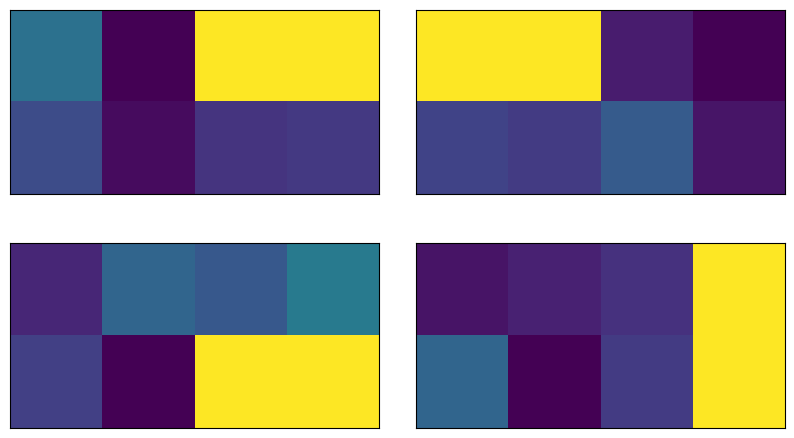

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(4):
    ax[i // 2, i % 2].imshow(
        train_images[i].reshape(2, 4),  # Change back to 2 by 4
        aspect="equal",
    )
plt.subplots_adjust(wspace=0.1, hspace=0.025)

### Defining the neural network ansatz
As mentioned previously, our ansatz is a quantum convolutional neural network (QCNN), consisting of alternating convolutional and pooling layers. 

We start by constructing the parametric two-qubit unitary which will be the building block of the convolutional layer. As a design choice, we implement these convolutional circuits as the 3-parameter gate set found in between the CNOT gate blocks of the [KAK decomposition](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.69.032315).

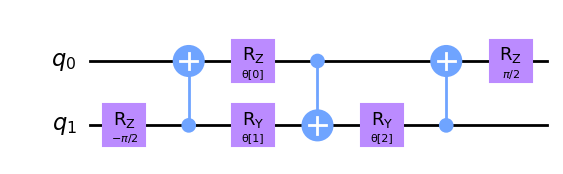

In [4]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector


def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target


# Display the convolutional circuit
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl", style="clifford")

The convolutional layer consists of these two-qubit unitaries laid out in non-overlapping nearest-neighbor topology in 2 layers as defined below.

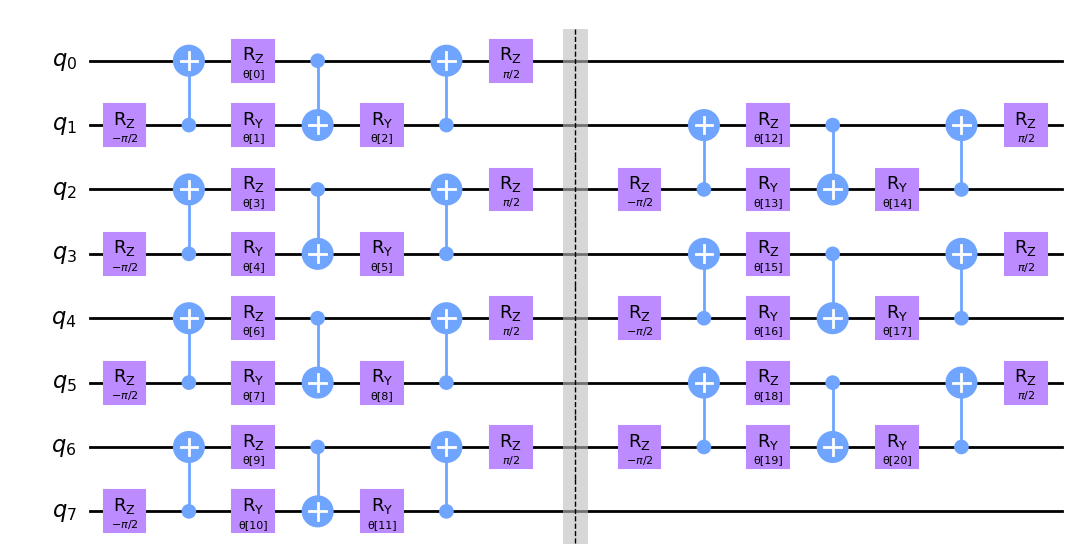

In [5]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        param_index += 3
    qc.barrier()
    for q1, q2 in zip(qubits[1::2], qubits[2::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


# Display the convolutional layer for an example of 8 qubits
circuit = conv_layer(8, "θ")
circuit.decompose().draw("mpl", style="clifford")

The pooling layer also consists of two-qubit unitaries, which we choose to design with 3 parameters as below.

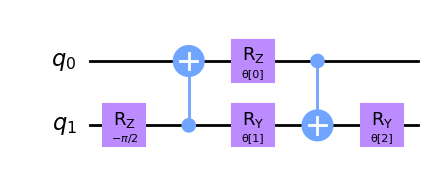

In [6]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


# Display the pooling circuit
params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl", style="clifford")

When putting the pooling layer together, we connect a pair of qubits with the two-qubit unitaries defined above. Then we trace out one of the qubits per pooling circuit block, i.e. we discard half of the qubits in the entire pooling layer and effectively reduce the system size by half.

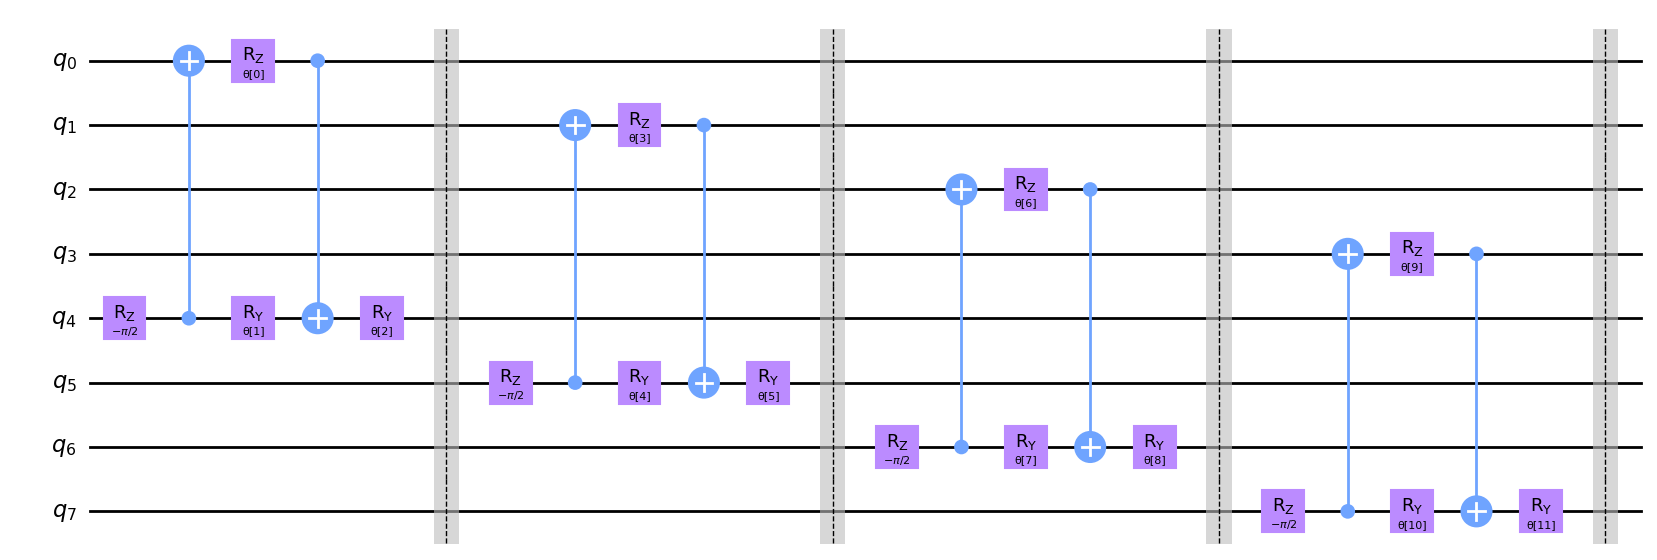

In [7]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


# Display the pooling layer with an example of 8 qubits, where source qubits are discarded afterwards
sources = [0, 1, 2, 3]
sinks = [4, 5, 6, 7]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl", style="clifford")

## Qiskit Patterns Step 1: Mapping the problem to quantum circuits
We are now ready to build the whole quantum circuit, which consists of a feature map to encode the data onto the quantum computer followed by the quantum convolutional neural network ansatz.

In [8]:
def get_qcnn_ansatz(num_qubits: int) -> QuantumCircuit:
    """
    Creates the quantum convolutional neural network (QCNN) ansatz.

    Args:
        num_qubits: number of qubits in the circuit.

    Returns:
        ansatz: QCNN ansatz as a QuantumCircuit object.
    """
    ansatz = QuantumCircuit(num_qubits, name="Ansatz")

    # Convolutional layer acts on "full_qubits" number of qubits
    # Pooling layer reduces "full_qubits" number of qubits to "half_qubits" number of qubits
    # If "full_qubits" is odd, take the larger half to ensure last pooling layer has 2->1 qubits
    full_qubits = num_qubits
    half_qubits = (num_qubits + 1) // 2

    # Add convolutional and pooling layers until there is only one qubit left for binary classification
    layer = 1
    pool_until = 1
    while full_qubits > pool_until:
        # Convolutional Layer
        ansatz.compose(conv_layer(num_qubits=full_qubits, 
                                  param_prefix=f"c{layer}"),
                       list(range(num_qubits - full_qubits, num_qubits)),
                       inplace=True)
        
        # Pooling Layer
        ansatz.compose(pool_layer(sources=list(range(0, half_qubits)),
                                  sinks=list(range(half_qubits, full_qubits)),
                                  param_prefix=f"p{layer}"),
                       list(range(num_qubits - full_qubits, num_qubits)),
                       inplace=True)

        full_qubits = half_qubits
        half_qubits = (half_qubits + 1) // 2
        layer += 1
    
    return ansatz

We encode the data onto the quantum computer using the Z Feature Map. This method uses one qubit per data feature, i.e. per pixel in this case. Then we add convolutional and pooling layers in an alternating fashion until we are left with a single qubit in the circuit. This is because we have a binary classification task and measuring a single qubit is sufficient to classify data into one of the two labels. 

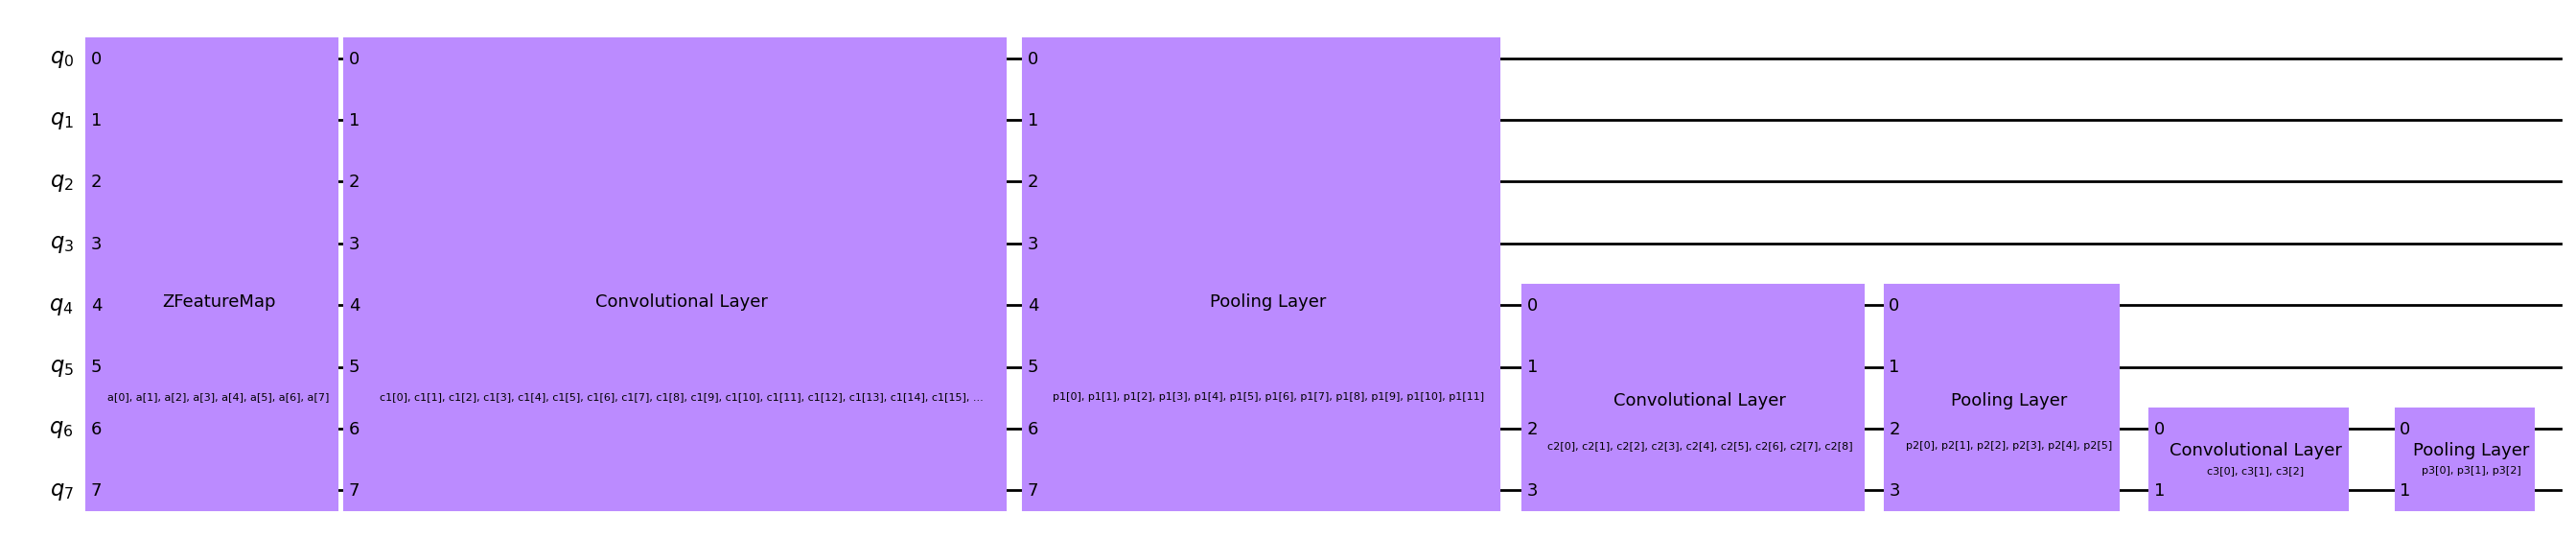

In [9]:
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp

# One qubit per data feature
num_qubits = len(train_images[0])

# Data encoding
# Note qiskit orders parameters alphabetically
feature_map = ZFeatureMap(num_qubits, parameter_prefix='a')

# QCNN ansatz
ansatz = get_qcnn_ansatz(num_qubits)

# Combine the feature map with the ansatz
circuit = QuantumCircuit(num_qubits)
circuit.compose(feature_map, range(num_qubits), inplace=True)
circuit.compose(ansatz, range(num_qubits), inplace=True)

# Display the circuit
circuit.draw("mpl", style="clifford", fold=-1)

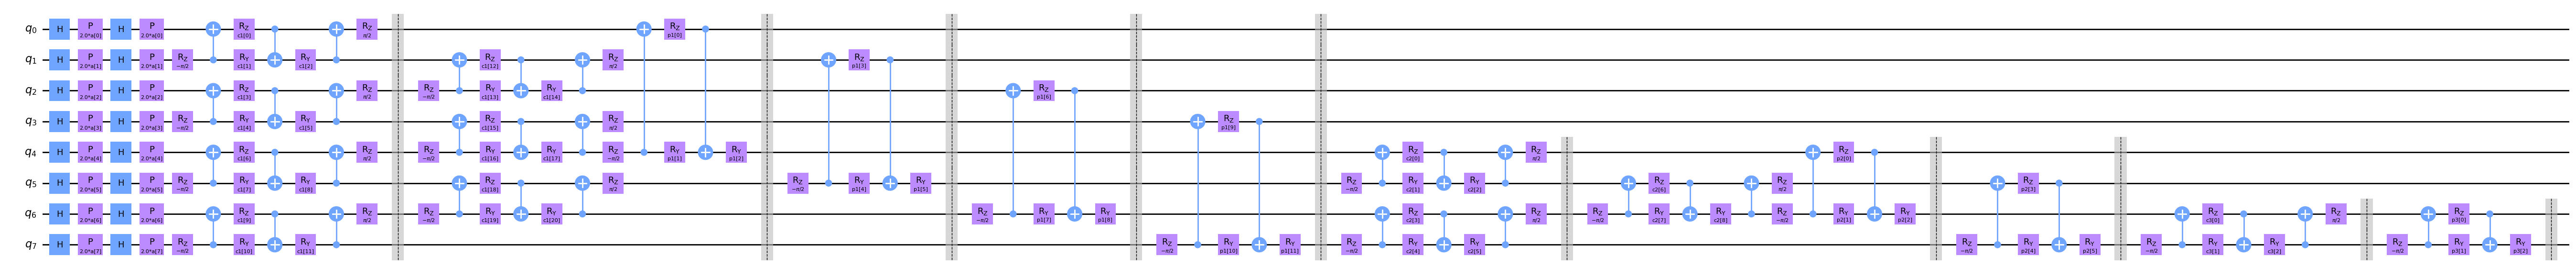

In [10]:
# Display the circuit
circuit.decompose().draw("mpl", style="clifford", fold=-1)

In [11]:
print(feature_map.parameters)
print(ansatz.parameters)
# Note that parameters are ordered alphabetically
print(circuit.parameters)

ParameterView([ParameterVectorElement(a[0]), ParameterVectorElement(a[1]), ParameterVectorElement(a[2]), ParameterVectorElement(a[3]), ParameterVectorElement(a[4]), ParameterVectorElement(a[5]), ParameterVectorElement(a[6]), ParameterVectorElement(a[7])])
ParameterView([ParameterVectorElement(c1[0]), ParameterVectorElement(c1[1]), ParameterVectorElement(c1[2]), ParameterVectorElement(c1[3]), ParameterVectorElement(c1[4]), ParameterVectorElement(c1[5]), ParameterVectorElement(c1[6]), ParameterVectorElement(c1[7]), ParameterVectorElement(c1[8]), ParameterVectorElement(c1[9]), ParameterVectorElement(c1[10]), ParameterVectorElement(c1[11]), ParameterVectorElement(c1[12]), ParameterVectorElement(c1[13]), ParameterVectorElement(c1[14]), ParameterVectorElement(c1[15]), ParameterVectorElement(c1[16]), ParameterVectorElement(c1[17]), ParameterVectorElement(c1[18]), ParameterVectorElement(c1[19]), ParameterVectorElement(c1[20]), ParameterVectorElement(c2[0]), ParameterVectorElement(c2[1]), Param

Our observable is the Pauli-Z operator on the last qubit. 

In [12]:
observable = SparsePauliOp.from_list([("Z" + "I" * (num_qubits - 1), 1)])

Before we optimize the circuit for a run on quantum hardware, we test the code on the simulator for small problem sizes. We define functions to run and train the circuit below.

### Load the data and do a forward pass
We write a function to do one forward pass of the quantum neural network. Then we test it with a small batch from the dataset and randomly initialized ansatz parameters.

In [13]:
from qiskit.primitives import BaseEstimatorV2
from qiskit.quantum_info.operators.base_operator import BaseOperator


def forward(circuit: QuantumCircuit,
            input_params: np.ndarray, 
            weight_params: np.ndarray, 
            estimator: BaseEstimatorV2,
            observable: BaseOperator
) -> np.ndarray:
    """
    Forward pass of the neural network.
    
    Args:
        circuit: circuit consisting of data loader gates and the neural network ansatz.
        input_params: data encoding parameters.
        weight_params: neural network ansatz parameters.
        estimator: EstimatorV2 primitive. 
        observable: a single oberservable to compute the expectation over.

    Returns:
        expectation_values: an array (for one observable) or a matrix (for a sequence of observables) of expectation values.
        Rows correspond to observables and columns to data samples.
    """
    num_samples = input_params.shape[0]
    weights = np.broadcast_to(weight_params, (num_samples, len(weight_params)))
    params = np.concatenate((input_params, weights), axis=1)
    pub = (circuit, observable, params)
    job = estimator.run([pub])
    result = job.result()[0]
    expectation_values = result.data.evs

    return expectation_values

Below is an example forward pass with two images from the dataset and randomly initialized ansatz parameters.

In [14]:
from qiskit.primitives import StatevectorEstimator as Estimator


np.random.seed(42)

result = forward(circuit=circuit, 
                 input_params=np.array(train_images[:2]), 
                 weight_params=np.random.rand(len(ansatz.parameters)) * 2 * np.pi, 
                 estimator=Estimator(), 
                 observable=observable)
print(result)

[0.03532339 0.13862284]


### Computing gradients with the parameter shift rule
We implement one example gradient evaluation of the expectation values using the [parameter shift rule](https://doi.org/10.1103/PhysRevA.99.032331), to be used with gradient-based optimizers. 
When using a gradient-free optimizer such as COBYLA, we can omit this function.

In [15]:
def param_shift_estimator_gradient(circuit: QuantumCircuit,
                                   input_params: np.ndarray, 
                                   weight_params: np.ndarray, 
                                   estimator: BaseEstimatorV2,
                                   observable: BaseOperator
) -> np.ndarray:
    """
    Compute the gradients of the expectation values using the parameter shift rule.

    Args:
        circuit: circuit consisting of data loader gates and the neural network ansatz.
        input_params: data encoding parameters.
        weight_params: neural network ansatz parameters.
        estimator: EstimatorV2 primitive. 
        observable: a single oberservable to compute the expectation over.

    Returns:
        weight_gradients: list of expectation value gradients with respect to weight parameters.
        Columns correspond to weight parameters, and rows to different inputs.
    """
    num_samples = input_params.shape[0]
    num_weight_params = len(weight_params)

    weights = np.broadcast_to(weight_params, (num_samples * num_weight_params, num_weight_params))
    inputs  = np.tile(input_params, (num_weight_params, 1))

    weights_plus = weights.copy()
    for j in range(num_weight_params):
        for i in range(num_samples):
            weights_plus[j * num_samples + i][j] = weight_params[j] + np.pi / 2 

    weights_minus = weights.copy()
    for j in range(num_weight_params):
        for i in range(num_samples):
            weights_minus[j * num_samples + i][j] = weight_params[j] - np.pi / 2 

    params_plus = np.concatenate((inputs, weights_plus), axis=1)
    params_minus = np.concatenate((inputs, weights_minus), axis=1)

    pub_plus = (circuit, observable, params_plus)
    pub_minus = (circuit, observable, params_minus)

    job = estimator.run([pub_plus, pub_minus])

    result_plus = job.result()[0]
    result_minus = job.result()[1]

    expectation_values_plus = result_plus.data.evs
    expectation_values_minus = result_minus.data.evs

    weight_gradients = (expectation_values_plus - expectation_values_minus) / 2
    weight_gradients = np.array(weight_gradients).reshape((num_weight_params, num_samples)).T
    
    return weight_gradients

We compute the gradients for all ansatz parameters for two images from the dataset.

In [16]:
from qiskit.primitives import StatevectorEstimator as Estimator

np.random.seed(12345)

input_params = np.array([train_images[0], train_images[1]])
weight_params = np.random.rand(len(ansatz.parameters)) * 2 * np.pi
estimator = Estimator()

weight_grads = param_shift_estimator_gradient(circuit, input_params, weight_params, estimator, observable)
print(weight_grads.shape)


(2, 54)


### Testing our gradients
We can test our gradient function implementation with the help of [qiskit-algorithms](https://qiskit-community.github.io/qiskit-algorithms/index.html) package. Note that qiskit-algorithms is an external package in [Qiskit Ecosystem](https://qiskit.github.io/ecosystem/).

In [17]:
from qiskit.primitives import Estimator  # EstimatorV1 due to Qiskit Algorithms
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient

# Define the estimator
# Qiskit Algorthms currently supports EstimatorV1
estimator = Estimator()
# Define the gradient
gradient = ParamShiftEstimatorGradient(estimator)

num_samples = input_params.shape[0]
num_features = input_params.shape[1]

weights = np.broadcast_to(weight_params, (num_samples, len(weight_params)))
params = np.concatenate((input_params, weights), axis=1)

# Test for an arbitrary sample
sample_idx = 1

# Evaluate the gradient of the circuits using parameter shift gradients
pse_grads = gradient.run(circuit, observable, [params[sample_idx]]).result().gradients
pse_weight_grads = pse_grads[0][num_features:]

# This prints true if our implementation is the same
print(np.allclose(pse_weight_grads, weight_grads[sample_idx]))

True


### Loss function
Now we define the loss function that will be minimized during training. For this example, we implement the mean squared error (MSE) loss function.

In [19]:
def mse_loss(predict: np.ndarray, target: np.ndarray) -> np.ndarray:
    """
    Mean squared error (MSE).

    prediction: predictions from the forward pass of neural network.
    target: true labels.

    output: MSE loss.
    """
    if len(predict.shape) <= 1:
        return ((predict - target) ** 2).mean()
    else:
        raise AssertionError ("input should be 1d-array")

Below is an example run of the loss function.

In [20]:
from qiskit.primitives import StatevectorEstimator as Estimator  # back to EstimatorV2

batch_size = 2
train_images_batch = np.array(train_images[:batch_size])
train_labels_batch = np.array(train_labels[:batch_size])
print(f"True labels: {train_labels_batch}")

np.random.seed(42)

pred_batch = forward(circuit=circuit, 
                     input_params=train_images_batch, 
                     weight_params=np.random.rand(len(ansatz.parameters)) * 2 * np.pi,
                     estimator=Estimator(),
                     observable=observable)
print(f"Predictions: {pred_batch}")

loss = mse_loss(predict=pred_batch, target=train_labels_batch)
print(f"Loss: {loss}")

True labels: [-1 -1]
Predictions: [0.03532339 0.13862284]
Loss: 1.184178242451296


### Cost function
We now define the cost function that will be provided to the optimizer. This function only takes the ansatz parameters as input; other variables for the forward pass and the loss are set as global parameters.

In [21]:
def cost_function(weight_params: np.ndarray) -> np.ndarray:
    """
    Cost function for the optimizer to update the ansatz parameters.

    weight_params: ansatz parameters to be updated by the optimizer.

    output: MSE loss.
    """
    predictions = forward(circuit=circuit, 
                          input_params=input_params, 
                          weight_params=weight_params, 
                          estimator=estimator, 
                          observable=observable)
    
    cost = mse_loss(predict=predictions, target=target)
    objective_func_vals.append(cost)
    
    global iter
    if iter % 50 == 0:
        print(f"Iter: {iter}, loss: {cost}")
    iter += 1

    return cost

We set the initial variables for the cost function.

In [22]:
# Globals
circuit = circuit
input_params = train_images_batch
estimator = Estimator()
observables = observable
target = train_labels_batch
objective_func_vals = []
iter = 0

Below is an example run of the cost function.

In [23]:
np.random.seed(42)
weight_params = np.random.rand(len(ansatz.parameters)) * 2 * np.pi
cost_function(weight_params)

Iter: 0, loss: 1.184178242451296


1.184178242451296

We also write a function that computes both the MSE cost and its gradient with respect to weight parameters. This function will only be called by gradient-based optimizers.

In [24]:
def cost_and_grad_function(weight_params):
    """
    Cost and the gradient function for the optimizer to update the ansatz parameters.

    Args:
        weight_params: ansatz parameters to be updated by the optimizer.

    Output: 
        cost: MSE loss.
        gradients: gradient of the MSE loss with respect to weight parameters.
    """
    predictions = forward(circuit=circuit, 
                          input_params=input_params, 
                          weight_params=weight_params, 
                          estimator=estimator, 
                          observable=observable)
    
    cost = mse_loss(predict=predictions, target=target)
    objective_func_vals.append(cost)

    gradients = param_shift_estimator_gradient(circuit=circuit, 
                                               input_params=input_params, 
                                               weight_params=weight_params, 
                                               estimator=estimator, 
                                               observable=observable)
    # Gradients of the MSE loss
    diff = np.reshape((predictions - target), (1, -1))
    gradient_vector = diff @ gradients * 2
    gradient_vector = np.reshape(gradient_vector, (-1))

    global iter
    print(f"Iter: {iter}, loss: {cost}")
    iter += 1

    return cost, gradient_vector

Below is an example run.

In [25]:
np.random.seed(42)
weight_params = np.random.rand(len(ansatz.parameters)) * 2 * np.pi
cost_and_grad_function(weight_params)

Iter: 1, loss: 1.184178242451296


(1.184178242451296,
 array([-9.73635503e-02,  2.90607919e-02,  2.92371447e-02, -1.83220260e-01,
        -8.16173174e-02,  1.08135151e-01,  2.25847817e-02, -1.10414480e-01,
        -9.70392311e-02, -2.14267714e-01,  4.48859608e-02,  1.54265814e-01,
        -5.44025296e-02,  1.18097785e-01,  2.17290967e-02, -1.50924377e-02,
         3.02143412e-02,  2.50517768e-02,  3.09498351e-02,  1.70949383e-01,
        -2.14613488e-01, -4.57851032e-02, -9.43863061e-02,  1.15150766e-02,
         1.55499039e-01, -3.00765083e-01, -7.89320359e-01, -1.25303057e-01,
        -1.57091473e-01,  2.47432338e-01, -9.91262603e-17, -5.11632142e-01,
         1.93187528e-01,  0.00000000e+00,  2.87367666e-02, -4.74870843e-03,
         3.16031323e-17, -1.66767353e-01, -3.86115833e-02, -1.70966252e-16,
        -7.90389908e-02, -3.59969443e-01, -1.43679983e-17, -4.53234582e-01,
         7.55213659e-02, -1.46547119e-16,  7.31008081e-02,  3.77530915e-02,
         0.00000000e+00,  2.09343686e-01, -9.61306142e-01,  1.449727

### Optimizer
Now we run the optimizer once for a small batch from the training data. We use the COBYLA method for minimization in this example.

In [26]:
from scipy.optimize import minimize

res = minimize(cost_function, weight_params, method='COBYLA', options={'maxiter': 300})
print(res)

Iter: 50, loss: 0.8452108010169597
Iter: 100, loss: 0.4951055010179454
Iter: 150, loss: 0.1043639483375415
Iter: 200, loss: 0.1164047704175796
Iter: 250, loss: 0.007016066683612002
Iter: 300, loss: 0.008054336419343503
 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: 0.005406553515892247
       x: [ 3.041e+00  7.237e+00 ...  5.673e+00  4.445e+00]
    nfev: 300
   maxcv: 0.0


We run a forward pass with the learned parameters to see accuracy over the small training batch.

In [27]:
print(f"Learned weights: {res['x']}")
pred_batch = forward(circuit, train_images_batch, res['x'], estimator, observable)
print(f"Forward pass expectations: {pred_batch}")

Learned weights: [ 3.04136266  7.23721475  4.90796555  4.74858607 -0.06221705  1.95919411
  0.14294464  5.19378045  4.71302214  5.18968837  1.34092247  8.16126145
  6.06594677  1.19130735  2.7756313   0.51918586  1.43804901  2.86731259
  3.54133744  2.29606527  4.1389571   2.46240586  1.69303441  3.71459939
  4.12221838  4.3448042   1.52458544  2.91071961  3.36304352  0.04466029
  4.56731689  2.46274125  0.09725305  8.46202367  7.18495553  5.2099957
  1.87984973  1.67575894  4.69249178  2.34388806  0.71997451  2.18789395
  0.2558983   4.83185251  1.60313854  4.43355953  1.61751653  2.61613918
  2.91839883  2.259583    4.79309013  5.115291    5.67287039  4.44528954]
Forward pass expectations: [-0.93910267 -0.91571108]


Since this is a classification task, we use the mean value 0 of the class labels as the cutoff value.

In [28]:
import copy

pred_labels_batch = copy.deepcopy(pred_batch)
pred_labels_batch[pred_labels_batch >= 0] = 1
pred_labels_batch[pred_labels_batch < 0] = -1

print(f"Predicted labels: {pred_labels_batch}")
print(f"True labels: {train_labels_batch}")

Predicted labels: [-1. -1.]
True labels: [-1 -1]


## Qiskit Patterns Step 2: Optimize problem for quantum execution

We start by selecting a backend for execution.

In [29]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel="ibm_quantum", instance="ibm-q/open/main")
backend = service.least_busy(operational=True, simulator=False)
print(backend.name)

ibm_sherbrooke


Here we optimize the circuit for running on a real backend by specifying the optimization_level and adding dynamical decoupling. The code below generates a mass manager using preset pass managers from qiskit.transpiler.

In [30]:
from qiskit.circuit.library import XGate
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import (
    ALAPScheduleAnalysis,
    ConstrainedReschedule,
    PadDynamicalDecoupling,
)
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
pm.scheduling = PassManager(
    [
        ALAPScheduleAnalysis(target=target),
        ConstrainedReschedule(target.acquire_alignment, target.pulse_alignment),
        PadDynamicalDecoupling(
            target=target, dd_sequence=[XGate(), XGate()], pulse_alignment=target.pulse_alignment
        ),
    ]
)

Now we use the pass manager on the initial state. We can similarly apply device layout characteristics to the observable to get a more physical representation.

In [31]:
circuit_ibm = pm.run(circuit)
observable_ibm = observable.apply_layout(circuit_ibm.layout)

## Qiskit Patterns Step 3: Execute using Qiskit Primitives

### Loop over the dataset in batches and epochs
We first implement the full algorithm using a simulator for cursory debugging and for estimates of error. We can now go over the entire dataset in batches in desired number of epochs to train our quantum neural network.

In [39]:
batch_size = 35
num_epochs = 1
num_samples = len(train_images)

# Globals
circuit = circuit
estimator = Estimator()  # simulator for debugging
observables = observable
objective_func_vals = []
iter = 0

# Random initial weights for the ansatz
np.random.seed(42)
weight_params = np.random.rand(len(ansatz.parameters)) * 2 * np.pi

for epoch in range(num_epochs):
    for i in range((num_samples - 1) // batch_size + 1):
        print(f"Epoch: {epoch}, batch: {i}")
        start_i = i * batch_size
        end_i = start_i + batch_size
        train_images_batch = np.array(train_images[start_i:end_i])
        train_labels_batch = np.array(train_labels[start_i:end_i])
        input_params = train_images_batch
        target = train_labels_batch
        iter = 0
        res = minimize(cost_function, weight_params, method='COBYLA', options={'maxiter': 1000})
        weight_params = res['x']



Epoch: 0, batch: 0
Iter: 0, loss: 1.0013021384464493
Iter: 50, loss: 0.8988555074915614
Iter: 100, loss: 0.7628055487183264
Iter: 150, loss: 0.7788079857327457
Iter: 200, loss: 0.6844030491371074
Iter: 250, loss: 0.6478703592143327
Iter: 300, loss: 0.5781510133556838
Iter: 350, loss: 0.5461730508570907
Iter: 400, loss: 0.4978965313286361
Iter: 450, loss: 0.473482067187513
Iter: 500, loss: 0.46388261715784945
Iter: 550, loss: 0.45806806678195117
Iter: 600, loss: 0.45029400561948807
Iter: 650, loss: 0.44627644433782687
Iter: 700, loss: 0.44233162108083485
Iter: 750, loss: 0.44160739439248076
Iter: 800, loss: 0.440143753656243
Iter: 850, loss: 0.4391586729786056
Iter: 900, loss: 0.43818804964766345
Iter: 950, loss: 0.43774765215024525


If we would like to use a gradient-based optimize instead, we can run the cell below.

In [56]:
batch_size = 35
num_epochs = 1
num_samples = len(train_images)

# Globals
circuit = circuit
estimator = Estimator()  # simulator for debugging
observables = observable
objective_func_vals = []
iter = 0

# Random initial weights for the ansatz
np.random.seed(42)
weight_params = np.random.rand(len(ansatz.parameters)) * 2 * np.pi

for epoch in range(num_epochs):
    for i in range((num_samples - 1) // batch_size + 1):
        print(f"Epoch: {epoch}, batch: {i}")
        start_i = i * batch_size
        end_i = start_i + batch_size
        train_images_batch = np.array(train_images[start_i:end_i])
        train_labels_batch = np.array(train_labels[start_i:end_i])
        input_params = train_images_batch
        target = train_labels_batch
        iter = 0
        res = minimize(cost_and_grad_function, weight_params, method='BFGS', jac=True, options={'disp': True, 'maxiter': 10})
        weight_params = res['x']

Epoch: 0, batch: 0
Iter: 0, loss: 1.0013021384464493
Iter: 1, loss: 0.9616124405029491
Iter: 2, loss: 0.9593197164689236
Iter: 3, loss: 0.9501330262492601
Iter: 4, loss: 0.9149300798176002
Iter: 5, loss: 0.91224248050783
Iter: 6, loss: 0.9016808132406134
Iter: 7, loss: 0.8659308844245013
Iter: 8, loss: 0.8631305766909787
Iter: 9, loss: 0.8525051032897298
Iter: 10, loss: 0.8517304097454138
Iter: 11, loss: 0.8486353834691429
Iter: 12, loss: 0.8363458890924125
Iter: 13, loss: 0.790934721388661
Iter: 14, loss: 0.7873961033727147
Iter: 15, loss: 0.7736238039330865
Iter: 16, loss: 0.7305036930895389
Iter: 17, loss: 0.7270640524718088
Iter: 18, loss: 0.714349811564467
Iter: 19, loss: 0.7134181784203941
Iter: 20, loss: 0.7097074498869945
Iter: 21, loss: 0.6952907929670569
Iter: 22, loss: 0.6590593304379527
Iter: 23, loss: 0.6559651153296127
Iter: 24, loss: 0.6455977553480631
Iter: 25, loss: 0.6448232303438566
Iter: 26, loss: 0.6417742556723521
Iter: 27, loss: 0.6304503623058628
         Curren

/opt/anaconda3/envs/quantum1/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


Alternatively, we can use the SPSA optimizer.

In [34]:
from qiskit_algorithms.optimizers import SPSA


spsa = SPSA(maxiter=100)

batch_size = 35
num_epochs = 1
num_samples = len(train_images)

# Globals
circuit = circuit
estimator = Estimator()  # simulator for debugging
observables = observable
objective_func_vals = []
iter = 0

# Random initial weights for the ansatz
np.random.seed(42)
weight_params = np.random.rand(len(ansatz.parameters)) * 2 * np.pi

for epoch in range(num_epochs):
    for i in range((num_samples - 1) // batch_size + 1):
        print(f"Epoch: {epoch}, batch: {i}")
        start_i = i * batch_size
        end_i = start_i + batch_size
        train_images_batch = np.array(train_images[start_i:end_i])
        train_labels_batch = np.array(train_labels[start_i:end_i])
        input_params = train_images_batch
        target = train_labels_batch
        iter = 0
        res = spsa.minimize(cost_function, x0=weight_params)
        weight_params = res.x


Epoch: 0, batch: 0
Iter: 0, loss: 0.9923538645069631
Iter: 50, loss: 1.0491942798654916
Iter: 100, loss: 0.9799959968320546
Iter: 150, loss: 0.8857701149698306
Iter: 200, loss: 0.8178654359214842
Iter: 250, loss: 0.7574209229582517


We are now ready to run the training on real hardware.

In [ ]:
# To continue running on real hardware use
from qiskit_ibm_runtime import EstimatorV2 as Estimator, EstimatorOptions, Session

batch_size = 35
num_epochs = 1
num_samples = len(train_images)

# Globals
circuit = circuit_ibm
observables = observable_ibm
objective_func_vals = []
iter = 0

# Random initial weights for the ansatz
np.random.seed(42)
weight_params = np.random.rand(len(ansatz.parameters)) * 2 * np.pi

with Session(backend=backend):
    session_options = EstimatorOptions()
    session_options.default_shots = 10000
    session_options.resilience_level = 1

    estimator = Estimator(session=Session(service, backend=backend), options=session_options)  # hardware
    
    for epoch in range(num_epochs):
        for i in range((num_samples - 1) // batch_size + 1):
            print(f"Epoch: {epoch}, batch: {i}")
            start_i = i * batch_size
            end_i = start_i + batch_size
            train_images_batch = np.array(train_images[start_i:end_i])
            train_labels_batch = np.array(train_labels[start_i:end_i])
            input_params = train_images_batch
            target = train_labels_batch
            iter = 0
            # We can replace this with other optimizers
            res = minimize(cost_function, weight_params, method='COBYLA', options={'maxiter': 1500})
            weight_params = res['x']

## Qiskit Patterns Step 4: Post-process, return result in classical format

### Testing and accuracy
We now interpret the results from training. We first test the training accuracy over the training set.

In [40]:
from sklearn.metrics import accuracy_score
from qiskit.primitives import StatevectorEstimator as Estimator  # simulator
# from qiskit_ibm_runtime import EstimatorV2 as Estimator  # hardware

estimator = Estimator()
# estimator = Estimator(backend=backend)

pred_train = forward(circuit, np.array(train_images), res['x'], estimator, observable)
# pred_train = forward(circuit_ibm, np.array(train_images), res['x'], estimator, observable_ibm)

print(pred_train)

pred_train_labels = copy.deepcopy(pred_train)
pred_train_labels[pred_train_labels >= 0] = 1
pred_train_labels[pred_train_labels < 0] = -1
print(pred_train_labels)
print(train_labels)

accuracy = accuracy_score(train_labels, pred_train_labels)
print(f"Train accuracy: {accuracy * 100}%")

[-0.09390355  0.45874848 -0.57343827  0.60371608  0.68416663 -0.30337543
  0.50806944  0.6433382   0.23476469  0.59818076  0.72405324  0.60110709
 -0.03611846  0.39301714  0.36442518  0.51957222 -0.7280917   0.39874926
 -0.6619111  -0.75414771  0.66798464  0.32584446 -0.10038303  0.43637671
  0.39385072  0.29094047 -0.24409827 -0.07560782  0.20853491 -0.23922216
  0.58716185  0.07707207  0.19127664  0.43264673  0.78270414]
[-1.  1. -1.  1.  1. -1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1.
 -1. -1.  1.  1. -1.  1.  1.  1. -1. -1.  1. -1.  1.  1.  1.  1.  1.]
[-1, -1, -1, 1, 1, -1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, 1]
Train accuracy: 94.28571428571428%


We now test the model accuracy over the test set.

In [41]:
pred_test = forward(circuit, np.array(test_images), res['x'], estimator, observable)
# pred_test = forward(circuit_ibm, np.array(test_images), res['x'], estimator, observable_ibm)

print(pred_test)

pred_test_labels = copy.deepcopy(pred_test)
pred_test_labels[pred_test_labels >= 0] = 1
pred_test_labels[pred_test_labels < 0] = -1
print(pred_test_labels)
print(test_labels)

accuracy = accuracy_score(test_labels, pred_test_labels)
print(f"Test accuracy: {accuracy * 100}%")

[-0.16285746  0.71801972  0.4283502  -0.24037397  0.55176844 -0.38751922
  0.03649525  0.42260929  0.44751901  0.19029177  0.47835348  0.43318434
  0.49879189  0.4579182   0.24163785]
[-1.  1.  1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
[-1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1]
Test accuracy: 93.33333333333333%


Finally, we plot how the loss decreases over iterations during training.

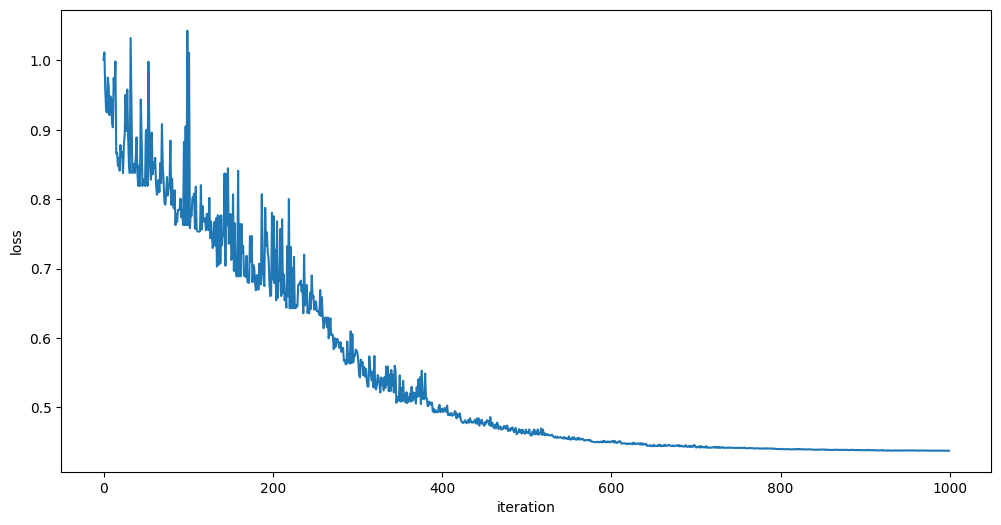

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()
